In [26]:
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,SystemMessage,ToolMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
import os
from lean_interact import LeanREPLConfig, AutoLeanServer, Command,LocalProject
from lean_interact.interface import CommandResponse
import nest_asyncio
from git import Repo
from typing import Optional, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated,Sequence,TypedDict,List
from langchain_community.chat_models import ChatTongyi
from utils import *
from typing import TypedDict, Union
import uuid


nest_asyncio.apply()
load_dotenv()

True

In [27]:
vec_store=VectorStore(r".\src\src_md",r".\src\src_VectorStore")
retriever_tool=vec_store.retriever_tool
#vec_store.sync_md(r".\src\src_pdf")

local_repo_path = "./mathlib4"
if not os.path.exists(local_repo_path):
    print(f"本地路径 {local_repo_path} 不存在，开始克隆 GitHub 仓库...")
    try:
        # 使用 ! 执行系统命令克隆仓库
        github_repo_url="https://github.com/leanprover-community/mathlib4.git"
        Repo.clone_from(github_repo_url, local_repo_path)
        print(f"GitHub 仓库 {github_repo_url} 已成功克隆到 {local_repo_path}")
    except Exception as e:
        print(f"克隆仓库时出错: {e}")
else:
    print(f"本地路径 {local_repo_path} 已存在，跳过克隆操作。")

config = LeanREPLConfig(project=LocalProject(directory=local_repo_path))
server = AutoLeanServer(config)
print(server.run(Command(cmd="theorem ex (n : Nat) : n = 5 → n = 5 := id")))

sync_store 完成
本地路径 ./mathlib4 已存在，跳过克隆操作。
CommandResponse(env=0)


In [28]:
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
)    

llm=ChatTongyi(model="qwen-max",temperature=0.0,max_tokens=None,timeout=None)

prover=Prover(model_ls=["deepseek/deepseek-prover-v2"])


In [29]:
class AgentState(TypedDict):
    initMessages: Annotated[Sequence[BaseMessage], add_messages]
    proverMessages : dict[str,BaseMessage]
    agentMessages : Annotated[Sequence[BaseMessage], add_messages]
    
class LeanState(TypedDict):
    query : str | None 
    background : str | None 
    leanQuery : str | None
    leanTheorem : str | None

class Tree(TypedDict):
    leaves : dict[str , list[Union[str,CommandResponse]]]

In [30]:
print(llm.invoke("HI"))
print(prover.ainvoke(r"use lean to prove 2 is not in \mathbb{Q}"))

content='Hello! How can I assist you today?' additional_kwargs={} response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': 'c9506b68-822c-9255-adef-4bbb0f402690', 'token_usage': {'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'prompt_tokens_details': {'cached_tokens': 0}}} id='run--7cef5361-6037-4828-a993-e1de19dd2fc4-0'
run prover
run agent
{'deepseek/deepseek-prover-v2_0': AIMessage(content="To prove that \\( \\sqrt{2} \\) is not in \\( \\mathbb{Q} \\) (i.e., \\( \\sqrt{2} \\) is irrational) using Lean, we can follow the standard proof by contradiction. Here's how you can formalize this in Lean:\n\n```lean\nimport data.rat.basic\nimport tactic\n\ntheorem sqrt_two_irrational : ¬ ∃ (q : ℚ), q^2 = 2 :=\nbegin\n  -- Proof by contradiction\n  assume h,\n  -- Extract the rational number q = a / b in lowest terms\n  cases h with q hq,\n  -- Obtain numerator `a` and denominator `b` (with `b ≠ 0` and `gcd a b = 1`)\n  cases q with a b hb h_coprime,\n  --

In [31]:
leanState:LeanState={}
tree:Tree={"leaves":{}}

@tool
def updateLeanState(stateName,text:str):
    """
    更新AgentState
    Args:
        stateName:leanState 其中元素的名称
        text:需要写入的内容
    """
    global leanState
    leanState[stateName]=text
    return f"leanState更新完成，更新了{stateName}"

@tool
def update_leaf_message(lean:str):
    """
    向树形结构添加新的解释信息
    
    参数:
        lean: 待解释的文本内容
    
    返回:
        包含操作结果的状态信息
    功能:
        1. 生成唯一标识符作为新节点ID
        2. 创建包含原始文本和解释结果的元组
        3. 将元组添加到树结构的leaves字典中
        4. 返回更新后的树结构信息
    
    依赖:
        - server.run(): 执行命令并返回lean解释器结果
        - uuid.uuid4(): 生成随机唯一标识符的函数
        - tree: 全局变量，存储树形结构的字典
    """
    global tree
    random_id=str(uuid.uuid4())
    tree['leaves'][random_id]=[lean,server.run(Command(cmd=lean))]
    print("节点更新")
    return f"leanMessages 已更新了节点 {random_id}"

@tool
def delete_leaf_message(leaf_id: str) -> dict:
    """
    从树结构中删除指定ID的叶子节点
    
    Args:
        leaf_id: 要删除的叶子节点ID
        
    Returns:
        包含操作结果的字典
    """
    global tree
    if leaf_id not in tree["leaves"]:
        return  f"error : 叶子节点ID '{leaf_id}'不存在"
        
    tree["leaves"].pop(leaf_id)
    print("节点删除")
    return f"叶子节点ID '{leaf_id}'已成功删除"

@tool
def save(filename: str, lean: str) -> str:
    """将lean证明保存为Lean格式的文本文件并结束流程。
    
    参数:
        filename: 文本文件名称。
        lean: 要保存的Lean代码内容。
    """

    # 确保文件名以.lean扩展名结尾
    if not filename.endswith('.lean'):
        filename = f"{filename}.lean"

    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(lean)
        print(f"文档已保存至: {filename}")
        return f"文档已成功保存至 '{filename}'。"
    
    except Exception as e:
        return f"保存文档时出错: {str(e)}"

In [32]:
systemPrompt={
    "init":"""
    Your tasks:
        1. You need to translate the content in leanState.query into Lean language and record it in leanState.leanQuery, or translate the content in leanState.leanQuery into natural language and record it in leanState.query. Here, you don't need to solve the problem, just perform the translation.

        2. You need to search for some background knowledge to help subsequent models understand. You should store the knowledge you find in leanState.background.

        3. You need to search for Lean theorems related to the problem. You should store the knowledge you find in leanState.leanTheorem.

    Tools you can use:
        1. updateLeanState - Used to update leanState
        2. search_lean_theorem - Used to search for Lean theorem content
        3. ddgs_search - Used to search web content
        4. retriever_tool - Used to search information in the knowledge base

    Structure of leanState:
        class LeanState(TypedDict):
            query : str | None 
            background : str | None 
            leanQuery : str | None
            leanTheorem : str | None
    """,
    "prover":f"""
    Your tasks:
        1. You need to write proofs with the assistance of leanState information
            Where:
                query is the natural language expression of the problem
                background contains some background knowledge about the problem
                leanQuery is the Lean language statement of the problem
                leanTheorem contains theorems that might be used for the problem

        2. You may refer to previously given proofs (not necessarily correct)
            The structure is {{"leaves": {{"leaf_id":["lean_proof","leanInterpreted"]}}}}
    """,
    "agent":f"""
    Your tasks:
        1. Summarize the information in proverMessages and record it in tree, while constantly updating or deleting content in tree (using tools delete_leaf_message or update_leaf_message). You need to ensure a 50% proof elimination rate.

        2. When you're satisfied with a proof in tree, you can use the save tool to save the proof (including: Lean proof and natural language proof comments), which will exit the program and complete the proof.

        3. When you find a proof referencing a non-existent theorem, you can use search_lean_theorem. You should store the knowledge you find in leanState.leanTheorem.

    Tools you can use:
        1. search_lean_theorem: Search for Lean theorems
        2. delete_leaf_message: Delete a proof from tree
        3. update_leaf_message: Update a proof
        4. updateLeanState: Update leanState
        5. save: Save the Lean proof

    Structure of tree:
        class Tree(TypedDict):
            leaves : dict[str , list[Union[str,CommandResponse]]]
            The structure is {{"leaves": {{"leaf_id":["lean_proof","leanInterpreted"]}}}}

    Structure of leanState:
        class LeanState(TypedDict):
            query : str | None 
            background : str | None 
            leanQuery : str | None
            leanTheorem : str | None
    """
}

init_tools=[updateLeanState,search_lean_theorem,ddgs_search,retriever_tool]
agent_tools=[search_lean_theorem,updateLeanState,save,delete_leaf_message,update_leaf_message]
init_llm=llm.bind_tools(init_tools)
agent_llm=llm.bind_tools(agent_tools)
def call_init_llm(state:AgentState)-> AgentState:
    system=SystemMessage(content=systemPrompt["init"])
    response=init_llm.invoke([system]+state["initMessages"])
    return {"initMessages":[response]}

def call_prover_llm(state:AgentState) -> AgentState:
    prompt = f"tree :{tree},leanState:{leanState}"
    system = systemPrompt["prover"] + prompt
    prover_results =prover.ainvoke(system)
    state["proverMessages"] = prover_results
    return state

def cal_agent_llm(state:AgentState)->AgentState:
    historymess = state.get("agentMessages", [])
    provermess=state["proverMessages"]
    prompt=f"tree:{tree},leanState:{leanState},proverMessages:{provermess}"
    full_prompt = HumanMessage(content=systemPrompt["agent"] + prompt)
    messages_to_send = historymess + [full_prompt]
    response=agent_llm.invoke(messages_to_send)
    return {"agentMessages": [full_prompt, response]}

def should_init_continue(state :AgentState):
    """check the last massage contants tool call"""
    result=state["initMessages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

def should_agent_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["agentMessages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        if (isinstance(message, ToolMessage) and 
            message.name=="save"):
            return "end" 
    return "continue"

def should_agent_prover(state:AgentState):
    result=state["agentMessages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

In [33]:
graph=StateGraph(AgentState)

init_tool_node=ToolNode(init_tools,messages_key="initMessages")
agent_tool_node=ToolNode(agent_tools,messages_key="agentMessages")

graph.add_node("init_node",call_init_llm)
graph.add_node("init_tool_node",init_tool_node)
graph.add_node("prover_node",call_prover_llm)
graph.add_node("agent_node",cal_agent_llm)
graph.add_node("agent_tool_node",agent_tool_node)

graph.add_edge(START,"init_node")
graph.add_edge("init_tool_node","init_node")
graph.add_edge("prover_node","agent_node")

graph.add_conditional_edges("init_node",should_init_continue,{True:"init_tool_node",False:"prover_node"})
graph.add_conditional_edges("agent_tool_node",should_agent_continue,{"continue":"agent_node","end":END})
graph.add_conditional_edges("agent_node",should_agent_prover,{True:"agent_tool_node",False:"prover_node"})
agent=graph.compile()

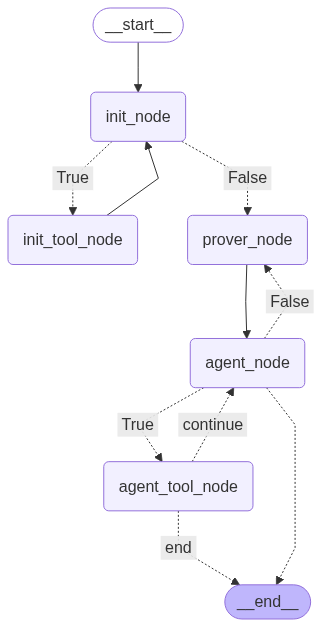

In [34]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [36]:
question="为什么根号二不是有理数？"
res=await agent.ainvoke({"initMessages":[HumanMessage(content=question)]},config={"recursion_limit":100})

run prover
run agent
节点更新
节点删除
文档已保存至: sqrt_two_irrational_proof.lean


In [37]:
res

{'initMessages': [HumanMessage(content='为什么根号二不是有理数？', additional_kwargs={}, response_metadata={}, id='005ae10d-70c8-4004-b898-4646b596124c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'name': 'updateLeanState', 'arguments': '{"stateName": "query", "text": "为什么根号二不是有理数？"}'}, 'index': 0, 'id': 'call_dfba2a880fbf4878a2749f', 'type': 'function'}]}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'tool_calls', 'request_id': '82d273c5-aa49-9a5a-8ecf-f1ba44d92451', 'token_usage': {'input_tokens': 822, 'output_tokens': 30, 'total_tokens': 852, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--832af271-67a3-4796-a226-42ff53b6a474-0', tool_calls=[{'name': 'updateLeanState', 'args': {'stateName': 'query', 'text': '为什么根号二不是有理数？'}, 'id': 'call_dfba2a880fbf4878a2749f', 'type': 'tool_call'}]),
  ToolMessage(content='leanState更新完成，更新了query', name='updateLeanState', id='5b93e472-ce2c-4f73-b29b-b110de9fbe95', tool_call_id='call_dfba2a880fbf4878a2749f'

In [38]:
leanState

{'query': '为什么根号二不是有理数？',
 'leanQuery': 'sqrt(2) ∉ ℚ',
 'background': '根号2可能是最早被发现的无理数。相传毕达哥拉斯学派的希帕索斯首先提出了“根号2不是有理数”的命题：若一个直角三角形的两个直角边都是1，那么它的斜边长度就是根号2。而根据有理数的定义，任何有理数都可以表示为两个整数之比，即a/b（其中a和b是整数且b不为0）。然而，根号2无法找到这样的两个整数来准确表达，因此它不是一个有理数。',
 'leanTheorem': '虽然搜索结果中没有直接给出证明根号2不是有理数的定理，但是这些定理和引理提供了关于有理数平方根的一些性质。例如，Rat.sqrt_eq表明任何有理数q的平方的平方根等于q的绝对值；Rat.sqrt_nonneg说明任何有理数的平方根是非负的。尽管这些定理并没有直接指出根号2是无理数，但它们有助于理解有理数及其平方根的性质。'}

In [39]:
tree

{'leaves': {'558c53e6-8b9d-4bfb-a292-b2ab97d84f58': ['import data.rat.basic\n\ntheorem sqrt_two_irrational : ¬ (∃ q : ℚ, q^2 = 2) :=\nbegin\n  -- Proof by contradiction: assume √2 is rational\n  assume h : ∃ q : ℚ, q^2 = 2,\n  \n  -- Get the reduced form p/q where p and q are coprime\n  obtain ⟨q, hq⟩ := h,\n  obtain ⟨p, q, hq, h_cop⟩ := exists_rat_coprime_of_sqrt ⟨q, hq⟩,\n  \n  -- From q^2 = 2, we get p^2 = 2*q^2\n  have h_pow : p^2 = 2 * q^2,\n  { rw [←rat.pow_mk, rat.ext_iff] at hq,\n    simp [hq] },\n  \n  -- This implies p is even (since p^2 is divisible by 2)\n  have p_even : 2 ∣ p,\n  { apply even_of_pow_even,\n    rw h_pow,\n    exact even_mul_right 2 (q^2) },\n  \n  -- Let p = 2k\n  obtain ⟨k, hk⟩ := p_even,\n  \n  -- Substitute back into the equation\n  have : 2 * (2 * k^2) = 2 * q^2,\n  { rw [←h_pow, hk], ring },\n  \n  -- Simplify to q^2 = 2*k^2\n  have : q^2 = 2 * k^2 := by linarith,\n  \n  -- This implies q is also even\n  have q_even : 2 ∣ q,\n  { apply even_of_pow_even

In [ ]:
server.run(Command(cmd="""import Mathlib

example : Irrational (√2) := by 
  apply irrational_sqrt_two"""))


CommandResponse(env=1)